# INTRODUÇÃO

Vamos utilizar o dataset da IBM, contendo informações do RH da empresa, para construir um modelo de Machine Learning para prever a saída de funcionários. Se a empresa tiver um bom modelo, será capaz de elaborar uma estratégia que consiga evitar saídas imprevistas que possam prejudicar o desempenho dos times e acabar com custos acima do esperado.

É importante que se avalie o trade-off do custo de retenção vs. o da saída destes funcionários.

# CARREGAR BIBLIOTECAS

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', None)

plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

# CARREGAR DATASET

In [2]:
hr_data = pd.read_csv('DataBase\WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [3]:
hr_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


- Attrition é a variavel que armazena se a pessoa se demitiu 
- DailyRate é a valor da diária

In [4]:
hr_data.shape

(1470, 35)

In [5]:
hr_data.nunique().sort_values()

Over18                         1
StandardHours                  1
EmployeeCount                  1
Gender                         2
Attrition                      2
PerformanceRating              2
OverTime                       2
MaritalStatus                  3
Department                     3
BusinessTravel                 3
StockOptionLevel               4
EnvironmentSatisfaction        4
JobInvolvement                 4
JobSatisfaction                4
RelationshipSatisfaction       4
WorkLifeBalance                4
Education                      5
JobLevel                       5
EducationField                 6
TrainingTimesLastYear          7
JobRole                        9
NumCompaniesWorked            10
PercentSalaryHike             15
YearsSinceLastPromotion       16
YearsWithCurrManager          18
YearsInCurrentRole            19
DistanceFromHome              29
YearsAtCompany                37
TotalWorkingYears             40
Age                           43
HourlyRate

In [6]:
hr_data.Attrition.value_counts(1)

Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64

In [7]:
hr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [8]:
hr_data["Attrition"] = hr_data.Attrition.map({"No":0, "Yes":1})

# MODELAGEM DE MACHINE LEARNING 

In [9]:
# Importando bibliotecas necessárias
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder, CatBoostEncoder, WOEEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression

Dividindo treino e teste

In [10]:
X = hr_data.drop('Attrition', axis=1)
y = hr_data['Attrition']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Com isso estamos colocando mais peso para o erro do 1, uma vez que por conta de termos muito mais 0 do que 1, o modelo esta prevendo apenas os 0's, uma vez que ainda sim a metrica ficaria boa, dando mais peso para o erro do 1, podemos fazer com que o modelo leve o acerto do 1 mais em consideração 

In [12]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}

In [13]:
weights_dict

{0: 0.6012269938650306, 1: 2.9696969696969697}

In [14]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

In [18]:
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy='median'))])
categorical_transformer = Pipeline(steps=[("encoder", TargetEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)                                      

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("select",SelectKBest(f_classif, k=25)), # Pegando apenas as 25 melhores featuatures(fazendo teste de hipotese)
    ("classifier", LogisticRegression(class_weight=weights_dict))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age', 'DailyRate',
                                                   'DistanceFromHome',
                                                   'Education', 'EmployeeCount',
                                                   'EmployeeNumber',
                                                   'EnvironmentSatisfaction',
                                                   'HourlyRate',
                                                   'JobInvolvement', 'JobLevel',
                                                   'JobSatisfaction',
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorke...
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder())]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole', 'MaritalStatus',
                                                   'Over18', 'OverTime'])])),
                ('select', SelectKBest(k=25)),
                ('classifier',
                 LogisticRegression(class_weight={0: 0.6012269938650306,
                                                  1: 2.9696969696969697}))])

In [16]:
y_pred = pipeline.predict(X_test)

In [17]:
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred)}")
print(f"Acc: {accuracy_score(y_test, y_pred)}")

y_pred_proba = pipeline.predict_proba(X_test)
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba[:,1])}")

Precision: 0.2037037037037037
Recall: 0.5641025641025641
F1: 0.29931972789115646
Acc: 0.6496598639455783
ROC AUC: 0.6398190045248868


- Precision: Das pessoas que nosso modelo previu que iriam sair, 18% realmente saíram 
- Recall: De todos que realmente saíram, nosso modelo previu 61.5% 

In [19]:
results = []

for thres in np.arange(0.05, 1, 0.05):
    
    y_pred = (pipeline.predict_proba(X_test)[:,1]>thres)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    results.append((thres, precision, recall, f1, acc))

In [20]:
results_df = pd.DataFrame(results, columns=["thres", "precision", "recall", "f1", "acc"])
results_df

,thres,precision,recall,f1,acc
0,0.05,0.134483,1.000000,0.237082,0.146259
1,0.10,0.138298,1.000000,0.242991,0.173469
2,0.15,0.145038,0.974359,0.252492,0.234694
3,0.20,0.158333,0.974359,0.272401,0.309524
4,0.25,0.153846,0.871795,0.261538,0.346939
5,0.30,0.160804,0.820513,0.268908,0.408163
6,0.35,0.176136,0.794872,0.288372,0.479592
7,0.40,0.180645,0.717949,0.288660,0.530612
8,0.45,0.187970,0.641026,0.290698,0.585034
9,0.50,0.203704,0.564103,0.299320,0.649660


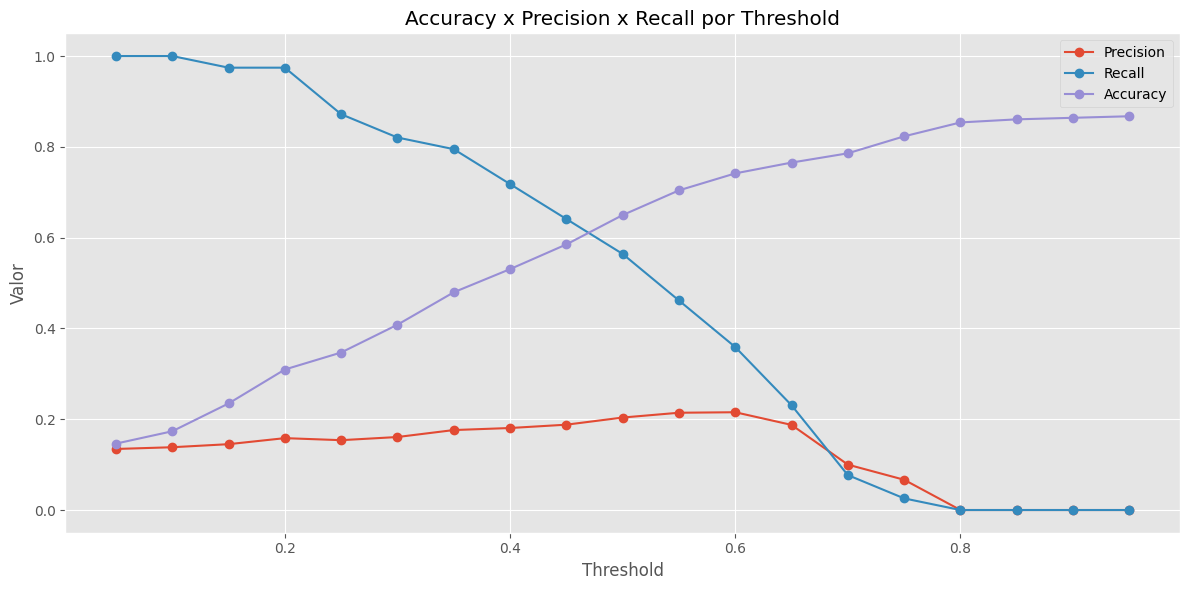

In [21]:
plt.figure(figsize=(12, 6))

plt.plot(results_df["thres"], results_df["precision"], label="Precision", marker='o')
plt.plot(results_df["thres"], results_df["recall"], label="Recall", marker='o')
plt.plot(results_df["thres"], results_df["acc"], label="Accuracy", marker='o')

plt.title("Accuracy x Precision x Recall por Threshold")
plt.xlabel("Threshold")
plt.ylabel("Valor")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# O QUE REALMENTE IMPORTA: O TRADE OFF

O que a gente realmente precisa ter em mente: Imagine o seguinte seu modelo tenta prever quem irá sair da empresa. A estratégia da empresa é oferecer uma bolsa de inglês para quem está mais propenso a sair. A gente descobre que a bolsa de inglês tem 60% de retenção.

Seu modelo diz que 40 pessoas vão sair, sendo que dessas 20 saem e 20 não saem. O que vai acontecer? Você vai oferecer bolsa a 20 pessoas, sendo que, dessas, 12 iriam sair e acabam ficando (60% de 20). Mas você gastou 20 bolsas que não precisava.

Resultado: 12 pessoas iriam sair e ficaram, 20 pessoas foram um gasto que não era necessário antes do modelo. Valeu a pena?


Cenário 1: Se cada pessoa que sai custa 1000 reais para a empresa e a bolsa de inglês custa 200 reais, você economizou 12000 reais e gastou 4000. Vale a pena subir o modelo!

Cenário 2: Cada pessoa que sai custa 3000 reais para a empresa e a bolsa de inglês custa 1000 reais. No caso, a empresa economizou 36000 reais e gastou 20000 reais. Ainda vale a pena!

Cenário: Cada pessoa que sai custa 3000 reais e a bolsa de inglês custa 2200 reais. A empresa economiza 36000 reais, mas gasta 44000 reais. Não vale a pena subir o modelo.